<img src="https://i.ibb.co/gV6Td9Z/image-1.png" alt="image-1" border="0">



![tryborg](https://preview.redd.it/80rfxi6nyia71.jpg?width=960&crop=smart&auto=webp&s=683e5f8dc9adaa6af8f0cb9e72f055a461cd349b)
<p style="font-size:120%;text-align:center">Be Tryborg :/</p>

<h1 style="font-size:50px;color:#2874A6"><strong>Notebook</strong> <strong style="color:black">Setup</strong></h1>

Source: [Github](https://github.com/ageron/handson-ml2)

<p style="font-size:120%">First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.</p>

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tensorflow.keras.utils import to_categorical

assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

<h1 style="font-size:50px;color:#2874A6"><strong>Vanishing/Exploding</strong> <strong style="color:black">Gradients Problem</strong></h1>

In [ ]:
def logit(z): #sigmoid function
    return 1 / (1 + np.exp(-z))

In [ ]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

<h1 style="font-size:50px;color:#2874A6"><strong> Xavier and He</strong> <strong style="color:black">Initialization</strong></h1>

In [ ]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

In [ ]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal") #kernel_initalizer is used for weight init

In [ ]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

<h1 style="font-size:50px;color:#2874A6"><strong>Nonsaturating </strong> <strong style="color:black">Activation Functions</strong></h1>

<p style="font-size:180%"><strong>Leaky ReLU</strong></p>

In [ ]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

In [ ]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [ ]:
[m for m in dir(keras.activations) if not m.startswith("_")]

In [ ]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

<p style="font-size:120%">Let's train a neural network on tps november using the Leaky ReLU:</p>

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-dec-2021/train.csv')
submission = pd.read_csv('../input/tabular-playground-series-dec-2021/sample_submission.csv')

In [ ]:
#reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train = reduce_mem_usage(train)

In [ ]:
y = train['Cover_Type']

train = train.drop(3403875) #droping single row of label 5
y = y.drop(3403875)

train = train.head(3000000) #just for fast computing remove these 2 lines to use full dataset
y = y.head(3000000)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

#no preprocessing done will do in next version...
std = StandardScaler()
encoder = OrdinalEncoder()

y = pd.DataFrame(to_categorical(encoder.fit_transform(y.values.reshape(-1,1))))

train.drop(['Id','Cover_Type','Soil_Type7', 'Soil_Type15'], axis=1, inplace=True)

X_train, X_test , y_train, y_test = train_test_split(train,y, stratify=y, test_size=0.2, random_state=42, shuffle=True)
X_train = pd.DataFrame(std.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(std.transform(X_test), columns = X_test.columns)

del train, y, std, encoder

gc.collect()

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
from keras import Input, layers, Model
from keras.layers import Dense

def get_model():
    #this function is used to get the keras functional model
    
    #setting up reuseability
    keras.backend.clear_session()
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)
    
    input_ = Input(shape=(X_train.shape[1])) #input shape where (batch_size, column numbers) we only specify column number here
    
    x = Dense(300,activation= 'LeakyReLU', kernel_initializer="he_normal")(input_) 
    x = Dense(100,activation= 'LeakyReLU', kernel_initializer="he_normal")(x)
    
    output_ = Dense(y_train.shape[1], activation='softmax')(x)
    
    model = Model(inputs=[input_], outputs =[output_])
    
    return model


In [ ]:
try:
    del model
except:
    model = get_model()

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=["acc",]);

gc.collect()

In [ ]:
history = model.fit(X_train, y_train, epochs=10,batch_size=2024,
                    validation_data=(X_test, y_test))

<p style="font-size:120%">Now let's try PReLU:

In [ ]:
def get_model():
    #this function is used to get the keras functional model
    
    #setting up reuseability
    keras.backend.clear_session()
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)
    
    input_ = Input(shape=(X_train.shape[1])) #input shape where (batch_size, column numbers) we only specify column number here
    
    x = Dense(300,activation= 'PReLU', kernel_initializer="he_normal")(input_) 
    x = Dense(100,activation= 'PReLU', kernel_initializer="he_normal")(x)
    
    output_ = Dense(y_train.shape[1], activation='softmax')(x)
    
    model = Model(inputs=[input_], outputs =[output_])
    
    return model

In [ ]:
model = get_model()

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=["acc",]);

In [ ]:
history = model.fit(X_train, y_train, epochs=10,batch_size=2024,
                    validation_data=(X_test, y_test))

del history, model

gc.collect()

<p style="font-size:180%"><strong>ELU</strong></p>

In [ ]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

In [ ]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

<p style="font-size:120%">Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [ ]:
keras.layers.Dense(10, activation="elu")

<p style="font-size:180%"><strong>SELU</strong></p>


<p style="font-size:120%">
This activation function was proposed in this <a href="https://arxiv.org/pdf/1706.02515.pdf">great paper</a> by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.</p>

In [ ]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [ ]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

In [ ]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

<p style="font-size:120%">
By default, the SELU hyperparameters <mark>(scale and alpha)</mark> are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:
</p>

In [ ]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

<p style="font-size:120%">Using SELU is easy:

In [ ]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

<p style="font-size:120%">Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[X_train.shape[1],]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(y_train.shape[1], activation="softmax"))

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=["acc",]);

<p style="font-size:120%">Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [ ]:
_means = X_train.values.mean(axis=0, keepdims=True)
_stds = X_train.values.std(axis=0, keepdims=True)
X_train_scaled = (X_train - _means) / _stds
X_test_scaled = (X_test - _means) / _stds

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,batch_size=1024,
                    validation_data=(X_test_scaled, y_test))

del model, history
gc.collect()

<p style="font-size:120%">Now look at what happens if we try to use the ReLU activation function instead:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[X_train.shape[1],]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(y_train.shape[1], activation="softmax"))

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=["acc",]);

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,batch_size=1024,
                    validation_data=(X_test_scaled, y_test))

del model, history
gc.collect()

<p style="font-size:120%">Not great at all, we suffered from the vanishing/exploding gradients problem.

<h1 style="font-size:50px;color:#2874A6"><strong>Batch</strong> <strong style="color:black">Normalization</strong></h1>

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(y_train.shape[1], activation="softmax")
])

In [ ]:
model.summary()

In [ ]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

In [ ]:
#bn1.updates #deprecated

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=["acc",]);

In [ ]:
history = model.fit(X_train, y_train, epochs=10,batch_size=1024,
                    validation_data=(X_test, y_test))

del model, history

gc.collect()

<p style="font-size:120%">Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a <mark>BatchNormalization</mark> layer does not need to have bias terms, since the <mark>BatchNormalization</mark> layer some as well, it would be a waste of parameters, so you can set <mark>use_bias=False</mark> when creating those layers:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(y_train.shape[1], activation="softmax")
])

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=["acc",]);

In [ ]:
history = model.fit(X_train, y_train, epochs=10,batch_size=1024,
                    validation_data=(X_test, y_test))

del model, history
gc.collect()

<h1 style="font-size:50px;color:#2874A6"><strong>Gradient </strong> <strong style="color:black">Clipping</strong></h1>

<p style="font-size:120%">All Keras optimizers accept <mark>clipnorm</mark> or <mark>clipvalue</mark> arguments:
    
    Gradient clipping is a technique to prevent exploding gradients in very deep networks, usually in recurrent neural networks. ... With gradient clipping, pre-determined gradient threshold be introduced, and then gradients norms that exceed this threshold are scaled down to match the norm.

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [ ]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

<h1 style="font-size:50px;color:#2874A6"><strong>Reusing</strong> <strong style="color:black">Pretrained Layers</strong></h1>

<h1 style="font-size:30px;color:#2874A6"><strong>Reusing a</strong> <strong style="color:black">Keras model</strong></h1>

<p style="font-size:120%">
Let's split the fashion MNIST training set in two:
<ul>
<li> <strong>X_train_A</strong>: all images of all items except for sandals and shirts (classes 5 and 6).</li>
<li> <strong>X_train_B</strong>: a much smaller training set of just the first 200 images of sandals or shirts.</li>

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).</p>

In [ ]:
(X_train_full, y_train_full), (_X_test, _y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
_X_test = _X_test / 255.0
_X_valid, _X_train = X_train_full[:5000], X_train_full[5000:]
_y_valid, _y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(_X_train, _y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(_X_valid, _y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(_X_test, _y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

# del _X_train, _X_valid, _y_valid, _y_train, _X_test, _y_test
gc.collect()

In [ ]:
X_train_A.shape

In [ ]:
X_train_B.shape

In [ ]:
y_train_A[:30]

In [ ]:
y_train_B[:30]

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [ ]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

In [ ]:
model_A.save("my_model_A.h5")

In [ ]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model_B.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

In [ ]:
model_B.summary()

In [ ]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

<p style="font-size:120%">Note that <mark>model_B_on_A</mark> and <mark>model_A</mark> actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build <mark>model_B_on_A</mark> on top of a <strong>clone</strong> of <mark>model_A</mark>:

In [ ]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="categorical_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="categorical_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

<p style="font-size:120%">So, what's the final verdict?

In [ ]:
model_B.evaluate(X_test_B, y_test_B)

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

<p style="font-size:120%">Great! We got quite a bit of transfer: the error rate dropped by a factor of 4.9!

In [ ]:
(100 - 97.05) / (100 - 99.40)

<h1 style="font-size:50px;color:#2874A6"><strong>Faster </strong> <strong style="color:black">Optimizers</strong></h1>

<p style="font-size:180%"><strong>Momentum optimization</strong></p>

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

<p style="font-size:180%"><strong>Nesterov Accelerated Gradient

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

<p style="font-size:180%"><strong>AdaGrad

In [ ]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

<p style="font-size:180%"><strong>RMSProp

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

<p style="font-size:180%"><strong>Adam Optimization

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

<p style="font-size:180%"><strong>Adamax Optimization

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

<p style="font-size:180%"><strong>Nadam Optimization

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

<p style="font-size:180%"><strong>Learning Rate Scheduling

<p style="font-size:180%"><strong>Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["acc",]);

In [ ]:
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,batch_size=1024,
                    validation_data=(X_test_scaled, y_test))

del model
gc.collect()

In [ ]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

<p style="font-size:180%"><strong>Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(y_train.shape[1], activation="softmax")
])

model.compile(loss="categorical_crossentropy",
              optimizer="nadam",
              metrics=["acc",]);
n_epochs = 20

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,batch_size=1024,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[lr_scheduler])

del model
gc.collect()

In [ ]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

<p style="font-size:120%">The schedule function can take the current learning rate as a second argument:

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

<p style="font-size:120%">If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [ ]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(y_train.shape[1], activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc",])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,batch_size=1024,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[exp_decay])

del model
gc.collect()

In [ ]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

In [ ]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

<p style="font-size:180%"><strong>Piecewise Constant Scheduling

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [ ]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["acc",])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,batch_size=1024,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[lr_scheduler])

del model
gc.collect()

In [ ]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

<p style="font-size:180%"><strong>Performance Scheduling

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(y_train.shape[1], activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc",])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[lr_scheduler])

del model
gc.collect()

In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

<p style="font-size:180%"><strong>tf.keras schedulers

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(y_train.shape[1], activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["AUC"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,batch_size=1024,
                    validation_data=(X_test_scaled, y_test))
del model
gc.collect()

<p style="font-size:120%">For piecewise constant scheduling, try this:

In [ ]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

<p style="font-size:180%"><strong>1Cycle scheduling

In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

**Warning**: In the `on_batch_end()` method, `logs["loss"]` used to contain the batch loss, but in TensorFlow 2.2.0 it was replaced with the mean loss (since the start of the epoch). This explains why the graph below is much smoother than in the book (if you are using TF 2.2 or above). It also means that there is a lag between the moment the batch loss starts exploding and the moment the explosion becomes clear in the graph. So you should choose a slightly smaller learning rate than you would have chosen with the "noisy" graph. Alternatively, you can tweak the `ExponentialLearningRate` callback above so it computes the batch loss (based on the current mean loss and the previous mean loss):

```python
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)
```

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["acc",])

In [ ]:
batch_size = 1024
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [ ]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[onecycle])

del  model
gc.collect()

<h1 style="font-size:50px;color:#2874A6"><strong>Avoiding Overfitting Through </strong> <strong style="color:black">Regularization</strong></h1>

<p style="font-size:180%"><strong>$\ell_1$ and $\ell_2$ regularization

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(y_train.shape[1], activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["acc",])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,batch_size=1024,
                    validation_data=(X_test_scaled, y_test))

del model
gc.collect()

In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["acc",])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,batch_size=1024,
                    validation_data=(X_test_scaled, y_test))

del model
gc.collect()

<p style="font-size:180%"><strong>Dropout

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["acc",])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,batch_size=1024,
                    validation_data=(X_test_scaled, y_test))

del model
gc.collect()

<p style="font-size:180%"><strong>Alpha Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(y_train.shape[1], activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc",])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,batch_size=1024,
                    validation_data=(X_test_scaled, y_test))

gc.collect()

In [ ]:
model.evaluate(X_test_scaled, y_test)

In [ ]:
model.evaluate(X_train_scaled, y_train)

In [ ]:
history = model.fit(X_train_scaled, y_train)

<p style="font-size:180%"><strong>MC Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
y_probas = np.stack([model(X_test_scaled.values, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [ ]:
np.round(model.predict(X_test_scaled[:1]), 2)

In [ ]:
np.round(y_probas[:, :1], 2)

In [ ]:
np.round(y_proba[:1], 2)

In [ ]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

In [ ]:
y_pred = np.argmax(y_proba, axis=1)

In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [ ]:
mc_model.summary()

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc",])

In [ ]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [ ]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

<p style="font-size:180%"><strong>Max norm

In [ ]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [ ]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["acc",])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,batch_size=1024,
                    validation_data=(X_test_scaled, y_test))

del model
gc.collect()

This notebook is forked from **Hands on machine learning with sklearn, tensorflow and keras book** github repo please check out the original author's work.([link](https://github.com/ageron/handson-ml2))

Thank you.


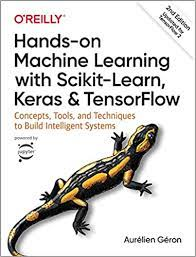